In [1]:
import pandas as pd
import numpy as np

import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils
import torch.utils.data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [2]:
train_file = "./kaggle/brist1d/train.csv"
test_file = "./kaggle/brist1d/test.csv"

df = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

print("Num features train", df.shape[1])
print("Num features test", df_test.shape[1])

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
        df_test[col] = df_test[col].astype('category')

df.dtypes

/tmp/ipykernel_31885/2519436331.py:4: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(train_file)


Num features train 508
Num features test 507


id               category
p_num            category
time             category
bg-5:55           float64
bg-5:50           float64
                   ...   
activity-0:15    category
activity-0:10    category
activity-0:05    category
activity-0:00    category
bg+1:00           float64
Length: 508, dtype: object

## Data Cleaning - handling missing values

In [3]:
features = df.columns
bg_cols = [col for col in features if "bg" in col]
insulin_cols = [col for col in features if "insulin" in col]
carbs_cols = [col for col in features if "carbs" in col]
hr_cols = [col for col in features if "hr" in col]
steps_cols = [col for col in features if "steps" in col]
cals_cols = [col for col in features if "cals" in col]
activity_cols = [col for col in features if "activity" in col]

Fill missing values for features based on:
- mean value: blood glucose, carbs, cals
- zeroes: insulin
- forward filled (i.e. propagates the last observation forward): heart rate, steps

In [4]:
for feature in [*bg_cols, *carbs_cols, *cals_cols]:
    if feature != "bg+1:00":
        df[feature] = df[feature].fillna(df[feature].mean())
        df_test[feature] = df_test[feature].fillna(df_test[feature].mean())

for feature in insulin_cols:
    df[feature] = df[feature].fillna(0)
    df_test[feature] = df_test[feature].fillna(0)

for feature in [*hr_cols, *steps_cols]:
    df[feature] = df[feature].fillna(method="ffill")
    df_test[feature] = df_test[feature].fillna(method="ffill")

    df[feature] = df[feature].fillna(method="bfill")
    df_test[feature] = df_test[feature].fillna(method="bfill")

print("NaNs in training data: ", df.isna().sum())
print("NaNs in testing data", df_test.isna().sum())

print("Num features train", df.shape[1])
print("Num features test", df_test.shape[1])

NaNs in training data:  id                    0
p_num                 0
time                  0
bg-5:55               0
bg-5:50               0
                  ...  
activity-0:15    174293
activity-0:10    174287
activity-0:05    174271
activity-0:00    174287
bg+1:00               0
Length: 508, dtype: int64
NaNs in testing data id                  0
p_num               0
time                0
bg-5:55             0
bg-5:50             0
                 ... 
activity-0:20    3580
activity-0:15    3587
activity-0:10    3586
activity-0:05    3581
activity-0:00    3583
Length: 507, dtype: int64
Num features train 508
Num features test 507


In [5]:
df['time'] = pd.to_timedelta(df['time']).dt.total_seconds()
df_test['time'] = pd.to_timedelta(df_test['time']).dt.total_seconds()

# for now we just ignore participant profiles
df.drop(columns=["p_num", "id", *activity_cols], inplace=True)
test_ids = df_test["id"]
df_test.drop(columns=["p_num", "id", *activity_cols], inplace=True)

# drop remaining NAs that could not be filled in
# df = df.dropna(how="any")
# df_test = df_test.dropna(how="any")

y = df["bg+1:00"]
df = df.drop("bg+1:00", axis=1)

print("Num features train", df.shape[1])
print("Num features test", df_test.shape[1])

Num features train 433
Num features test 433


In [6]:
print("Data train shape", df.shape)
print("Data test shape", df_test.shape)

Data train shape (177024, 433)
Data test shape (3644, 433)


### Normalize features

In [ ]:
# scale features
scaler = StandardScaler()
df = scaler.fit_transform(df)
df_test = scaler.fit_transform(df_test)
y = scaler.fit_transform(np.reshape(y.values, (-1, 1)))

# transform to tensor and reshape
df_tensor = torch.Tensor(df)
df_test_tensor = torch.Tensor(df_test)
y_tensor = torch.Tensor(y)
print(df_tensor.shape)
print(y_tensor.shape)

# create dataloader
BATCH_SIZE = 32

dataset = torch.utils.data.TensorDataset(df_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


torch.Size([177024, 433])
torch.Size([177024, 1])


#### Checking the data before feeding it into the network

In [8]:
for col in range(df_tensor.shape[1]):
    if df_tensor[:, col].isnan().sum() != 0:
        print(f"Col {col} with {df_tensor[:, col].isnan().sum()} missing values")

### RNN (LSTM)

In [ ]:
class RNN(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm_1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        #self.lstm_2 = nn.LSTM(input_size=hidden_size[0], hidden_size=hidden_size[1], num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_size, 1)
        #self.pos_out = nn.ReLU()

    
    def forward(self, x):
        x, _ = self.lstm_1(x)
        #x, _ = self.lstm_2(x)
        #print("LSTM in, lstm out", x.shape)
        out = self.dropout(x)
        #print(out.shape)
        pred = self.linear(out)

        return pred


In [ ]:
model = RNN(input_size=df_tensor.size(1), batch_size=BATCH_SIZE, hidden_size=[20, 12], num_layers=1)

optimizer = optim.Adam(model.parameters(), lr=0.001)
mse_loss = torch.nn.MSELoss()

In [11]:
losses = []

for i in tqdm.tqdm(range(30)):
    loss = 0
    for j, (data, target) in tqdm.tqdm(enumerate(dataloader)):
        optimizer.zero_grad()

        prediction = model.forward(data)
      
        #print("Pred, target", prediction[0], target[0], prediction.shape, target.shape)

        batch_loss = mse_loss(prediction, target)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.detach().item()
        #print("Loss:", batch_loss.detach().item())
    losses.append(loss/BATCH_SIZE)
    #print("Loss:", losses[-1])

692it [00:12, 54.44it/s]0:00<?, ?it/s]
692it [00:11, 59.79it/s]0:12<06:08, 12.72s/it]
692it [00:10, 62.97it/s]0:24<05:37, 12.05s/it]
692it [00:11, 61.67it/s]0:35<05:12, 11.57s/it]
692it [00:10, 65.63it/s]0:46<04:57, 11.43s/it]
692it [00:09, 69.83it/s]0:57<04:37, 11.11s/it]
692it [00:10, 64.07it/s]1:06<04:16, 10.71s/it]
692it [00:10, 67.15it/s]1:17<04:06, 10.74s/it]
692it [00:10, 64.87it/s]1:28<03:53, 10.60s/it]
692it [00:10, 65.56it/s]1:38<03:43, 10.62s/it]
692it [00:10, 66.67it/s]01:49<03:32, 10.60s/it]
692it [00:09, 72.59it/s]01:59<03:20, 10.54s/it]
692it [00:10, 64.19it/s]02:09<03:04, 10.23s/it]
692it [00:10, 66.76it/s]02:20<02:56, 10.40s/it]
692it [00:09, 70.58it/s]02:30<02:46, 10.39s/it]
692it [00:09, 69.49it/s]02:40<02:33, 10.22s/it]
692it [00:10, 64.90it/s]02:50<02:21, 10.14s/it]
692it [00:09, 70.06it/s]03:00<02:13, 10.30s/it]
692it [00:10, 64.51it/s]03:10<02:02, 10.17s/it]
692it [00:10, 68.44it/s]03:21<01:53, 10.34s/it]
692it [00:09, 73.75it/s]03:31<01:42, 10.27s/it]
692it [00:

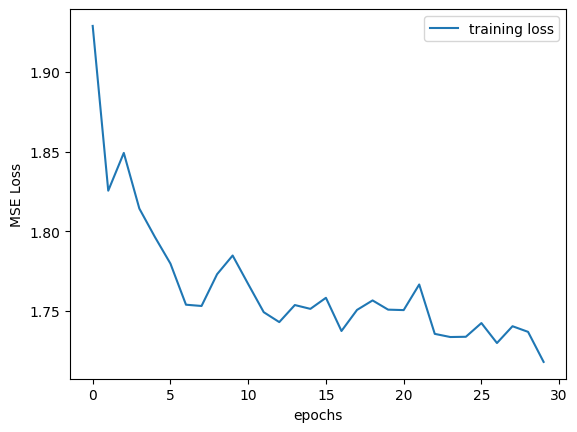

In [12]:
plt.plot(losses, label="training loss")
plt.xlabel("epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

### Make predictions and compute MSE

In [13]:
orig_df_test = pd.read_csv(test_file)
df_test_std = np.mean(orig_df_test, axis=1)
df_test_std = np.std(orig_df_test, axis=1)

/home/coco/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/coco/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3571: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [14]:
# Make predictions
with torch.no_grad():
    y_test_pred = model(df_test_tensor)

y_test_pred_inv_transformed = scaler.inverse_transform(y_test_pred)
print(y_test_pred_inv_transformed)
print(test_ids.shape, y_test_pred.shape, df_test_tensor.shape, type(y_test_pred))
out = np.column_stack([test_ids, y_test_pred_inv_transformed])
out = pd.DataFrame(out, columns=["id", "bg+1:00"])

out.to_csv("submission.csv", index=False)

[[7.35387135]
 [6.33173996]
 [7.39142933]
 ...
 [7.17717905]
 [7.09137557]
 [6.89716058]]
(3644,) torch.Size([3644, 1]) torch.Size([3644, 433]) <class 'torch.Tensor'>
